# YouTube API Project - CBC News Analysis

## Introduction

CBC News is a 'national public news and information service' that keeps Canadians up-to-date with important information in connection with people's communities and the world around them. Recently, since inception in October 1972, CBC News Marketplace celebrated its' 50th season on air. I enjoy the CBC Marketplace videos and value the awareness and investigative work completed by the team involved. Out of curiosity, I decided to analyze the CBC News YouTube Channel using the YouTube Data API and analyze CBC News Marketplace video statistics in-depth and explore which videos attracted the most user consumption and engagement, in the form of video views, likes, and comments.

I will aim to answer the following questions:
 
1. How does the CBC News YouTube channel compare to other Canadian News YouTube channels?
2. What is the most popular CBC Marketplace video?
3. Is there a relationship between the number of views and the number of likes in a video? Title length? Comments? Duration? Tags?
4. How often are the videos published throughout the week? 
5. What types of topics are the videos covering, based on analysis of video titles?


## Methods

Using the YouTube Data API guidelines, I obtained authorization credentials for API requests of YouTube's various entities. In order to retrieve statistics data for individual videos, the following steps were implemented in this notebook:

1) Retrieve unique identifier information on specific channels by accessing the YouTube channel of interest and reviewing the HTML source code.
2) Using the API to retrieve specific channel and playlist resource properties information, such as the unique video identifier information.
3) Using the API to retrieve video properties and statistics information with the unique video ids.

Upon completing the above steps, a dataset of the videos information in the CBC Marketplace playlist were created and processed for cleaning and enrichment prior to downstream analyses.

### Import Packages

These are the list of packages I imported for this notebook.

In [90]:
# Array and dataframe manipulation libraries
import numpy as np
import pandas as pd

# Date/time/duration parsing library
import isodate

# Plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# File storing library
import pickle

# Datetime parser
from dateutil.parser import parse

# API Client Library
from googleapiclient.discovery import build

# JSON display library
from IPython.display import JSON

# Natural Language Processing libraries
import nltk
import re  # regular expression
import string  # string functions

from PIL import Image
from nltk.corpus import stopwords  # import module for stopwords
from wordcloud import WordCloud, ImageColorGenerator

### Define Functions

Function that will retrieve a YouTube channel's statistics.

In [2]:
def get_channel_stats(youtube_api, channel_ids):

    '''
    Make a query to retrieve information on specified YouTube channel resource and methods

    Parameters
    ----------
    youtube_api : obj
        API client object
    channel_ids : str
        The Youtube channel IDs of interest

    Returns
    -------
    all_channel_data
        A dataframe containing the results of the retrieved channel information
    '''

    # Initialize empty dataframe
    all_channel_data = []

    # Create request variable using the 'channels' resource and
    # specifying the 'parts' parameters for channel details (i.e., snippet),
    # channel content (i.e., contentDetails),
    # and channels statistics (i.e., statistics)
    channels_response = youtube_api.channels().list(part='snippet,contentDetails,statistics', id=','.join(channel_ids)).execute()

    # Loop through each channel's items
    # Format total counts as f strings to output numbers with commas for readability
    for item in channels_response['items']:

        data = {'Channel_Name': item['snippet']['title'],
                'Channel_Create_Date': item['snippet']['publishedAt'],
                'Total_Subscribers': int(item['statistics']['subscriberCount']),
                'Total_Channel_Views': int(item['statistics']['viewCount']),
                'Total_Videos': int(item['statistics']['videoCount']),
                'Playlist_Id': item['contentDetails']['relatedPlaylists']['uploads'],
                }

        all_channel_data.append(data)

    return pd.DataFrame(all_channel_data)

Define the function that will retrieve the video IDs in the channel's playlist.

In [3]:
def get_video_ids(youtube_api, playlist_id):

    '''
    Make a query to retrieve information on the specified YouTube playlist

    Parameters
    ----------
    youtube_api : obj
        API client object
    playlist_id : str
        The playlist ID of interest

    Returns
    -------
    video_ids
        A dataframe containing the the unique video IDs
    '''

    # Initialize empty dataframe
    video_ids = []

    # Create request variable using the 'playlistItems' resource and
    # specifying the 'parts' parameters for playlist details (i.e., snippet),
    # and its' content (i.e., contentDetails)

    # Specified maxResults parameter to the maximum allotted
    # value
    playlist_response = youtube_api.playlistItems().list(part='contentDetails, status', 
                                                         playlistId=playlist_id, 
                                                         maxResults=50).execute()


    # Loop through each playlist's items (i.e., video)
    # Retrieve the video ID and append to empty dataframe
    for item in playlist_response['items']:
        video_ids.append({'Video_ID': item['contentDetails']['videoId'],
                          'Status': item['status']['privacyStatus']})
        
    # Retrieve the next page token ID if the
    # number of videos in the playlist exceed
    # 50 results
    next_page_token = playlist_response.get('nextPageToken')

    # For as long as there is a next page token,
    # continue to retrieve the video IDs
    # and append it to the dataframe
    while next_page_token is not None:
        
        playlist_response = youtube_api.playlistItems().list(part='contentDetails, status', 
                                                             playlistId=playlist_id, maxResults=50, 
                                                             pageToken=next_page_token).execute()


        # Repeat video IDs and next page token retrieval
        for item in playlist_response['items']:
            
            video_ids.append({'Video_ID': item['contentDetails']['videoId'],
                              'Status': item['status']['privacyStatus']})

        next_page_token = playlist_response.get('nextPageToken')

    return pd.DataFrame(video_ids)

Define the function for retrieving specific video details and statistics. Note that this function is defined for compiled video IDs that exceed 50 results. In addition, the `favoriteCount` has been deprecated as of Aug 2015 and `dislikeCount` is only available to the video owner.

In [4]:
def get_video_stats(youtube_api, video_ids):

    '''
    Make a query to retrieve information on videos

    Parameters
    ----------
    youtube_api : obj
        API client object
    video_ids : str
        The video IDs of interest

    Returns
    -------
    video_data
        A dataframe containing the results of the retrieved video metadata and statistics
    '''

    # Initialize empty dataframe
    video_data = []

    # Due to the API request limit of 50 results per query/request made,
    # a for loop is implemented to iterate through every 50 videos IDs
    # previously compiled
    for i in range(0, len(video_ids), 50):

        # Create request variable using the 'videos' resource
        videos_response = youtube_api.videos().list(part='snippet,contentDetails,statistics,status',
                                                    id=','.join(video_ids[i : (i + 50)]['Video_ID'])).execute()

        # Loop through each video's items
        for item in videos_response['items']:

            # Specify which fields/attributes are of interest
            # from each method applied
            attributes_of_interest = {'snippet': ['title', 'publishedAt', 'description', 'tags'],
                                      'contentDetails': ['duration', 'definition', 'caption'],
                                      'statistics': ['viewCount', 'likeCount', 'commentCount']}

            # Instantiate empty dictionary
            video_info = {}

            # Compile the video_id used to
            # request data and store it
            # for data compilation
            video_info['video_id'] = item['id']

            # For each attribute of interest specified,
            # try to extract the value and save it
            # in the instantiated dictionary
            for key in attributes_of_interest.keys():

                # This for loop is implemented to overcome
                # any errors that arise from any empty values,
                # such as the 'commentCount' being empty
                for j in attributes_of_interest[key]:

                    try:
                        video_info[j] = item[key][j]

                    except:
                        video_info[j] = None

            video_data.append(video_info)

    return pd.DataFrame(video_data)

Define function for retrieving a video's comments.

In [5]:
def get_video_top_level_comments(youtube_api, video_id):

    '''
    Make a query to retrieve information on videos

    Parameters
    ----------
    youtube_api : obj
        API client object
    video_id : str
        The video ID of interest (single video)
        
    Returns
    -------
    comments_data
        A dataframe containing the results of the retrieved video comments 
        (only top-level comments)
    '''

    # Initialize empty dataframe
    comments_data = []
        
    # Create request variable using the 'commentThreads' resource and query it
    comments_response = youtube_api.commentThreads().list(part = 'snippet',
                                                          videoId = video_id,
                                                          textFormat = 'plainText',
                                                          order = 'time',
                                                          maxResults = 100).execute()
    
    # Loop through each comment
    for item in comments_response['items']:
        comments_data.append({'VideoComment': item['snippet']['topLevelComment']['snippet']['textOriginal']})
    
    next_page_token = comments_response.get('nextPageToken')        
        
    # For as long as there is a next page token,
    # continue to retrieve the comment text
    # and append it to the dataframe
    while next_page_token is not None:
        comments_response = youtube_api.commentThreads().list(part = 'snippet',
                                                              videoId = video_id,
                                                              maxResults = 100,
                                                              textFormat = 'plainText',
                                                              order = 'time',
                                                              pageToken = next_page_token).execute()

        # Loop through each comment
        for item in comments_response['items']:
            comments_data.append({'VideoComment': item['snippet']['topLevelComment']['snippet']['textOriginal']})
            
        next_page_token = comments_response.get('nextPageToken')
        
    return pd.DataFrame(comments_data)

Define function for text preprocessing, including removal of punctuation marks and stop words.

In [6]:
def text_preprocess(text_string):
    
    '''
    Removes specified punctuation marks and stop words.
    
    Parameters
    ----------
    text_string : Input text, in this case, video title strings

    Returns
    -------
    text_processed : Text preprocessed video title strings
    
    '''

    assert isinstance(text_string, str), 'Input string arguments only'   
    
    text_processed = []
    
    text_string = re.sub('[%s]' % re.escape(':()\/|?#'), '', text_string)
    text_string = str(text_string).split()
    text_processed = ' '.join([word for word in text_string if word not in stop_words])
        
    return text_processed

## YouTube API - Data Creation on News Channels

Load my unique API key for access.

In [7]:
# Load text file that contains my unique api key
my_developer_key = open('api_key.txt').read()

Instantiate YouTube API client.

In [8]:
# API Information
# https://developers.google.com/youtube/v3/docs/channels/list?apix=true
api_service_name = 'youtube'
api_version = 'v3'

# Create API client
youtube_api = build(api_service_name, api_version, developerKey=my_developer_key)

I have extracted the unique CBC News YouTube channel identification. In addition, CBC News hosts several other related YouTube channels. I have compiled those channels along with other known Canadian News YouTube channels for comparison, which I have limited to 10 channels in total. By no means is this an exhaustive list of all the Canadian News channels and a limitation to the analyses.

In [9]:
# CBC News Channel ID
channel_1 = 'UCuFFtHWoLl5fauMMD5Ww2jA'

# CBC News: The National Channel ID
channel_2 = 'UCKjU3KzdbJE1EFcHVqXC3_g'

# The Fifth Estate Channel ID
channel_3 = 'UCa-bX3gZC3YnCThlGM5d38Q'

# CBC Channel ID
channel_4 = 'UC5ujvySyX2svDmsle_--dpA'

# CTV News Channel ID
channel_5 = 'UCi7Zk9baY1tvdlgxIML8MXg'

# CP24 (Toronto-based) Channel ID
channel_6 = 'UCs3o4RhBiP2wcwqkZR2QVLw'

# Breakfast Telvision (Toronto-based) Channel ID
channel_7 = 'UCrygFy9ZCNFrR3vtElhXaJg'

# CityNews Channel ID
channel_8 = 'UCVKAcQQCO8vv87Gk62SutAg'

# Global News Channel ID
channel_9 = 'UChLtXXpo4Ge1ReTEboVvTDg'

# BNNBloomberg Channel ID
channel_10 = 'UC5aNPmKYwbudeNngDMTY3lw'

Store the Channel IDs into a list.

In [10]:
# Create a list of the channels
channel_ids = [channel_1,
               channel_2,
               channel_3,
               channel_4,
               channel_5,
               channel_6,
               channel_7,
               channel_8,
               channel_9,
               channel_10]

With the IDs stored, I will retrieve each channel's information and statistics. Outlined below is a brief example of the output from the API.

In [11]:
# Create request from the channel resource on the specified ID of the YouTube channel of interest (in this case, CBC News)
channels_response = youtube_api.channels().list(part='snippet, contentDetails, statistics', 
                                                id='UCuFFtHWoLl5fauMMD5Ww2jA').execute()

In [12]:
# Display results in JSON format
JSON(channels_response['items'])

<IPython.core.display.JSON object>

The results from this example display different information from the specified part parameter, such as the details about the channel and statistics.

Retrieve channel details using `get_channel_stats` function.

In [13]:
# channel_stats = get_channel_stats(youtube_api, channel_ids)

Display the results, with sorted by descending order of total subscribers to each YouTube channel.

In [14]:
# # Sort results in descending order, based on Total_Subscribers
# channel_stats_sorted = channel_stats.sort_values(by='Total_Subscribers', ascending=False).reset_index(drop=True)

# # Format numeric columns to display comma thousands separator
# channel_stats_sorted['Total_Subscribers'] = channel_stats_sorted['Total_Subscribers'].apply(lambda x: '{:,}'.format(x))
# channel_stats_sorted['Total_Channel_Views'] = channel_stats_sorted['Total_Channel_Views'].apply(lambda x: '{:,}'.format(x))
# channel_stats_sorted['Total_Videos'] = channel_stats_sorted['Total_Videos'].apply(lambda x: '{:,}'.format(x))

In [15]:
# # Saving the data as a pickle file
# with open('channel_data.pickle', 'wb') as f:
#     pickle.dump(channel_stats_sorted, f)

In [16]:
# Loading the pickle file into a variable
with open('channel_data.pickle', 'rb') as f:
    channel_stats_sorted = pickle.load(f)

In [17]:
# Display the dataframe
channel_stats_sorted

,Channel_Name,Channel_Create_Date,Total_Subscribers,Total_Channel_Views,Total_Videos,Playlist_Id
0,Global News,2009-11-04T20:46:32Z,"3,460,000","1,977,175,008","33,170",UUhLtXXpo4Ge1ReTEboVvTDg
1,CBC News,2014-07-25T13:46:46Z,"3,260,000","1,787,285,918","24,223",UUuFFtHWoLl5fauMMD5Ww2jA
2,CBC News: The National,2007-10-17T21:34:25Z,"1,460,000","880,559,245","25,383",UUKjU3KzdbJE1EFcHVqXC3_g
3,CTV News,2015-02-02T20:08:27Z,"888,000","661,783,246","18,536",UUi7Zk9baY1tvdlgxIML8MXg
4,The Fifth Estate,2016-06-08T21:55:11Z,"782,000","153,231,116",357,UUa-bX3gZC3YnCThlGM5d38Q
5,CityNews,2011-01-27T14:35:04Z,"416,000","423,810,495","48,586",UUVKAcQQCO8vv87Gk62SutAg
6,CBC,2007-03-02T19:34:49Z,"409,000","211,029,950","6,246",UU5ujvySyX2svDmsle_--dpA
7,Breakfast Television,2014-11-06T12:19:15Z,"68,800","36,772,641","8,640",UUrygFy9ZCNFrR3vtElhXaJg
8,CP24,2015-04-10T15:52:32Z,"55,400","35,841,547","3,596",UUs3o4RhBiP2wcwqkZR2QVLw
9,BNN Bloomberg,2014-08-28T16:21:11Z,"54,200","13,267,530","2,064",UU5aNPmKYwbudeNngDMTY3lw


In comparing some of the local and national Canadian news YouTube channels, `Global News` has the most subscribers and channel views. Surprisingly, the ranking of each channel is identical when comparing the total number of subscribers and the total channel views, with the exception of `CityNews`. Interestingly, when comparing total videos uploaded for a given channel, `CityNews` uploaded the most videos but ranked 6th in total subscribers and 5th in total channel views, whereas `CBC News` ranked 4th in the most videos uploaded but ranked 2nd in both total subscribers and channel views.

## CBC News Marketplace - Playlist Data

In reviewing the CBC News YouTube channel, the Marketplace videos can be found in a separate playlist titled 'Marketplace'. I will obtain the unique id for the playlist and extract the unique video ids found in the playlist in order to retrieve video statistics in downstream API requests.

In [18]:
# # Playlist ID for CBC Marketplace videos from CBC News YouTube channel
# # Link to playlist: https://www.youtube.com/playlist?list=PLeyJPHbRnGaZmzkCwy3-8ykUZm_8B9kKM
# cbc_marketplace_playlist_id = 'PLeyJPHbRnGaZmzkCwy3-8ykUZm_8B9kKM'

Retrieve all the video ids from the playlist using the `get_video_ids` function.

In [19]:
# video_ids = get_video_ids(youtube_api, cbc_marketplace_playlist_id)

In [20]:
# # Saving the data as a pickle file
# with open('cbc_marketplace_video_ids.pickle', 'wb') as f:
#     pickle.dump(video_ids, f)

In [21]:
# Loading the pickle file into a variable
with open('cbc_marketplace_video_ids.pickle', 'rb') as f:
    video_ids = pickle.load(f)

Display the video IDs.

In [22]:
video_ids

,Video_ID,Status
0,CoeN_Ej-FH0,private
1,xzmLjpNHf7I,public
2,EQmO49LNLCY,public
3,T2UISJYs19Y,public
4,aJrCKjVKqk4,public
...,...,...
368,0Og9OOorciQ,public
369,WtQeQzUfYrI,public
370,eCk8eFiaE98,public
371,_MG6J2z2dVE,public


There is a total of 373 unique video IDs retrieved from the playlist at this time. This corresponds with the total number of videos, as displayed in the YouTube channel playlist (screenshot below).

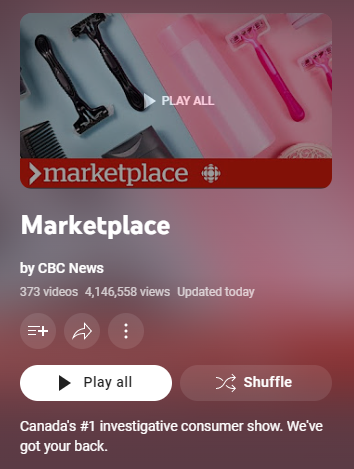

### Video Statistics Data

I will now retrieve detailed information from each video using the `get_video_stats` function.

In [23]:
# video_df = get_video_stats(youtube_api, video_ids)

In [24]:
# # Saving the data as a pickle file
# with open('video_df.pickle', 'wb') as f:
#     pickle.dump(video_df, f)

In [25]:
# Loading the pickle file into a variable
with open('video_df.pickle', 'rb') as f:
    video_df = pickle.load(f)

Display the results.

In [26]:
video_df

,video_id,title,publishedAt,description,tags,duration,definition,caption,viewCount,likeCount,commentCount
0,xzmLjpNHf7I,Who's paying more? Investigating gender-based ...,2023-03-25T00:00:31Z,Marketplace investigates the pricing inequalit...,"[pink tax, gender-based pricing, pricing, pric...",PT13M6S,hd,true,42344,485,188
1,EQmO49LNLCY,Customers say a pool builder took their money ...,2023-03-25T00:00:07Z,Kurt Wittin sells prefabricated pools made fro...,"[pools, prefabricated pools, pool, quick build...",PT7M20S,hd,true,28566,237,46
2,T2UISJYs19Y,Dog DNA testing kits: How accurate are they? (...,2023-03-04T01:00:20Z,Curious about what breed your dog is? You're n...,"[dog, dogs, pets, DNA, dog DNA tests, DNA test...",PT13M41S,hd,true,64398,998,199
3,aJrCKjVKqk4,What you should know about palm oil (Marketplace),2023-03-04T01:00:00Z,Trying to avoid palm oil? It could be harder t...,"[palm oil, oil, products, consumers, shampoo, ...",PT7M17S,hd,true,24721,358,63
4,838Ps6yw6ac,Canada’s rental crisis: The search for an affo...,2023-02-25T01:00:03Z,The Canada Mortgage and Housing Corporation (C...,"[rent, rentals, renters, tenants, tenant, apar...",PT21M47S,hd,true,240741,2690,1755
...,...,...,...,...,...,...,...,...,...,...,...
363,0Og9OOorciQ,Is Subway's wheat bread healthy? (CBC Marketpl...,2014-09-03T20:56:42Z,Is Subway's whole wheat bread as healthy as pe...,"[Whole Grain (Food), Subway (Restaurant), Fast...",PT3M59S,hd,false,151759,1097,172
364,WtQeQzUfYrI,Financial advisors: Hidden camera investigatio...,2014-09-03T17:53:21Z,"Originally broadcast February 28, 2014\n\nMark...","[Investment (Industry), Investment Banking (In...",PT17M37S,hd,false,1402323,8713,1399
365,eCk8eFiaE98,Pesticides in tea: Testing the chemicals in yo...,2014-08-15T21:49:58Z,"We tested tea for pesticides, and found stuff ...","[Pesticide (Literature Subject), Tea (Beverage...",PT4M22S,sd,false,137625,349,45
366,_MG6J2z2dVE,Brain training exercises and games: Do they wo...,2015-04-11T03:03:25Z,Can brain training exercises and games prevent...,"[CBC News, CBCNews, CBC broadcasting media, pu...",PT45M4S,hd,false,1550571,5001,595


The results displayed 368 rows of data. However, I previously saw 373 videos identified in the playlist.

In reviewing the `video_ids` variable, we can see that the privacy status for the videos are not all the same.

In [27]:
# Obtain count for each privacy status in the dataframe
video_ids.Status.value_counts()

public     368
private      5
Name: Status, dtype: int64

Given that 5 of the videos are in private mode, that leaves me with 368 public videos available. This corresponds with the correct number of rows of data that I would expect from the `videos` resource API requests.

### Data Cleaning and Preprocessing

Prior to conducting any analyses, I will first inspect and clean the datasets provided. This process will include the following:

1. Fixing data type columns
2. Evaluating and removing redundant columns
3. Removing duplicate rows/columns and `NaN` values

#### Data Overview

Retrieve a brief summary of the data types and non-null count within the dataframe.

In [28]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      368 non-null    object
 1   title         368 non-null    object
 2   publishedAt   368 non-null    object
 3   description   368 non-null    object
 4   tags          367 non-null    object
 5   duration      368 non-null    object
 6   definition    368 non-null    object
 7   caption       368 non-null    object
 8   viewCount     368 non-null    object
 9   likeCount     368 non-null    object
 10  commentCount  348 non-null    object
dtypes: object(11)
memory usage: 31.8+ KB


In reviewing the output, I can see that there are a few issues relating to data quality. For instance, observing the `Non-Null Count` column shows that the `commentCount` and `tags` columns contains null (missing) values. In addition, the columns are all stored as an object data type (string) rather than a datetime, string, or numeric data type. 

Prior to visualization and analysis, I will perform data cleaning procedures to ensure valid data quality.

#### Fix Data Type Column and Remove Missing Values

I will convert the `viewCount`, `likeCount`, and `commentCount` columns into a numeric data type.

In [29]:
numeric_columns = ['viewCount', 'likeCount', 'commentCount']

video_df[numeric_columns] = video_df[numeric_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')

In [30]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   video_id      368 non-null    object 
 1   title         368 non-null    object 
 2   publishedAt   368 non-null    object 
 3   description   368 non-null    object 
 4   tags          367 non-null    object 
 5   duration      368 non-null    object 
 6   definition    368 non-null    object 
 7   caption       368 non-null    object 
 8   viewCount     368 non-null    int32  
 9   likeCount     368 non-null    int32  
 10  commentCount  348 non-null    float64
dtypes: float64(1), int32(2), object(8)
memory usage: 28.9+ KB


It appears that `viewCount`, and `likeCount` converted to the intended `integer` data type. However, the `commentCount` converted into a `float64` data type and a result of the missing values. I will impute the missing values with 0 and convert it to an `integer`. Furthermore, `tags` has a missing value as well and will be imputed with 0.

In [31]:
# Impute missing values with 0
video_df.loc[video_df['commentCount'].isna(), 'commentCount'] = 0

Reapply data type conversion to `commentCount` column data.

In [32]:
video_df['commentCount'] = video_df['commentCount'].astype('int')

Check if the data type change has been applied correctly.

In [33]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      368 non-null    object
 1   title         368 non-null    object
 2   publishedAt   368 non-null    object
 3   description   368 non-null    object
 4   tags          367 non-null    object
 5   duration      368 non-null    object
 6   definition    368 non-null    object
 7   caption       368 non-null    object
 8   viewCount     368 non-null    int32 
 9   likeCount     368 non-null    int32 
 10  commentCount  368 non-null    int32 
dtypes: int32(3), object(8)
memory usage: 27.4+ KB


The changes have been successfully applied. Next, I will inspect and convert the `publishedAt` column into a `datetime` column.

In [34]:
video_df['publishedAt']

0      2023-03-25T00:00:31Z
1      2023-03-25T00:00:07Z
2      2023-03-04T01:00:20Z
3      2023-03-04T01:00:00Z
4      2023-02-25T01:00:03Z
               ...         
363    2014-09-03T20:56:42Z
364    2014-09-03T17:53:21Z
365    2014-08-15T21:49:58Z
366    2015-04-11T03:03:25Z
367    2015-05-05T15:54:35Z
Name: publishedAt, Length: 368, dtype: object

The outputted format from the [API](https://developers.google.com/youtube/v3/docs/videos) is an ISO 8601, where you have the date followed by the time of the video being published. Using the parse function from [dateutil](https://dateutil.readthedocs.io/en/stable/parser.html) module, I will convert the column into a datetime data type.

In [35]:
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parse(x))

In [36]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype                  
---  ------        --------------  -----                  
 0   video_id      368 non-null    object                 
 1   title         368 non-null    object                 
 2   publishedAt   368 non-null    datetime64[ns, tzutc()]
 3   description   368 non-null    object                 
 4   tags          367 non-null    object                 
 5   duration      368 non-null    object                 
 6   definition    368 non-null    object                 
 7   caption       368 non-null    object                 
 8   viewCount     368 non-null    int32                  
 9   likeCount     368 non-null    int32                  
 10  commentCount  368 non-null    int32                  
dtypes: datetime64[ns, tzutc()](1), int32(3), object(7)
memory usage: 27.4+ KB


#### Data Enrichment


##### Video Publishing - Day of Week

Using the method from `datetime`, I will extract the full weekday name for when each video was published and create a new column to store the results.

In [37]:
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime('%A'))

In [38]:
video_df['publishedDayName']

0       Saturday
1       Saturday
2       Saturday
3       Saturday
4       Saturday
         ...    
363    Wednesday
364    Wednesday
365       Friday
366     Saturday
367      Tuesday
Name: publishedDayName, Length: 368, dtype: object

In [39]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype                  
---  ------            --------------  -----                  
 0   video_id          368 non-null    object                 
 1   title             368 non-null    object                 
 2   publishedAt       368 non-null    datetime64[ns, tzutc()]
 3   description       368 non-null    object                 
 4   tags              367 non-null    object                 
 5   duration          368 non-null    object                 
 6   definition        368 non-null    object                 
 7   caption           368 non-null    object                 
 8   viewCount         368 non-null    int32                  
 9   likeCount         368 non-null    int32                  
 10  commentCount      368 non-null    int32                  
 11  publishedDayName  368 non-null    object                 
dtypes: datet

##### Video Duration

Take a look at the `duration` column.

In [40]:
video_df['duration']

0       PT13M6S
1       PT7M20S
2      PT13M41S
3       PT7M17S
4      PT21M47S
         ...   
363     PT3M59S
364    PT17M37S
365     PT4M22S
366     PT45M4S
367       PT33S
Name: duration, Length: 368, dtype: object

Similarly, the duration is formatted using ISO 8601, with PT referring to `period of time` and `M`/`S` indicating the number of minutes and seconds that precedes each letter. Using the `isodate` module, parse the duration into seconds and store in a new column `durationInSeconds`.

In [41]:
video_df['durationInSeconds'] = video_df['duration'].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))

Preview the column data.

In [42]:
video_df['durationInSeconds']

0       786
1       440
2       821
3       437
4      1307
       ... 
363     239
364    1057
365     262
366    2704
367      33
Name: durationInSeconds, Length: 368, dtype: int64

##### Total Tags

Next, I will count the total number of `tags` of a video and store the data into a new column `tagsTotalCount`.

In [43]:
video_df['tagsTotalCount'] = video_df['tags'].apply(lambda x: len(x) if x is not None else 0)

Preview the column data.

In [44]:
video_df['tagsTotalCount']

0      38
1      31
2      37
3      39
4      39
       ..
363    13
364    11
365    13
366    16
367    14
Name: tagsTotalCount, Length: 368, dtype: int64

##### Video Title Length

Next, I will count the total characters of a video title and store the data into a new column `titleCharacterLength`.

In [45]:
video_df['titleCharacterLength'] = video_df['title'].apply(lambda x: len(x) if x is not None else 0)

Preview the data.

In [46]:
video_df['titleCharacterLength']

0      77
1      79
2      58
3      49
4      71
       ..
363    50
364    65
365    70
366    67
367    57
Name: titleCharacterLength, Length: 368, dtype: int64

##### Ratio of Likes and Comments to Total Views

I will now calculate the ratio of likes and comments (converted into percentage) to their respective total views and store them in new columns `likesAndViewsPercent` and `commentsAndViewsPercent`.

In [47]:
video_df['likesAndViewsPercent'] = (video_df['likeCount']/ video_df['viewCount']) * 100

In [48]:
video_df['likesAndViewsPercent']

0      1.145381
1      0.829658
2      1.549738
3      1.448161
4      1.117383
         ...   
363    0.722857
364    0.621326
365    0.253588
366    0.322526
367    0.317158
Name: likesAndViewsPercent, Length: 368, dtype: float64

In [49]:
video_df['commentsAndViewsPercent'] = (video_df['commentCount']/ video_df['viewCount']) * 100

In [50]:
video_df['commentsAndViewsPercent']

0      0.443983
1      0.161031
2      0.309016
3      0.254844
4      0.728999
         ...   
363    0.113338
364    0.099763
365    0.032698
366    0.038373
367    0.000000
Name: commentsAndViewsPercent, Length: 368, dtype: float64

I will now convert the columns into their appropriate data types.

In [51]:
video_df = video_df.convert_dtypes()

Check to see if the changes were appropriate applied.

In [52]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype                  
---  ------                   --------------  -----                  
 0   video_id                 368 non-null    string                 
 1   title                    368 non-null    string                 
 2   publishedAt              368 non-null    datetime64[ns, tzutc()]
 3   description              368 non-null    string                 
 4   tags                     367 non-null    object                 
 5   duration                 368 non-null    string                 
 6   definition               368 non-null    string                 
 7   caption                  368 non-null    string                 
 8   viewCount                368 non-null    Int32                  
 9   likeCount                368 non-null    Int32                  
 10  commentCount             368 non-null    Int32    

The conversion have been successfully applied to the data columns.

#### Evaluate for Redundant Data and Remove Duplicates

I will check for redundant information within the dataset that need to be removed.

In [53]:
# I cannot implement duplicated method due to unhashable list error that arises from the `tags` column
# containing a list in each cell. I will convert it into tuples to avoid the error.
video_df['tags'] = video_df['tags'].apply(lambda x: tuple(x) if x is not None else 'None')

In [54]:
# Check for duplicate row data and convert the total true/false into percentage
print(video_df.duplicated().value_counts())

# Check for duplicate column data and convert the total true/false into percentage
video_df.T.duplicated().value_counts()

False    368
dtype: int64


False    17
dtype: int64

No duplicates were found. Let's start exploring the data for trends and patterns.

### Exploratory Data Analysis - CBC Marketplace Videos

#### What are the 10 most popular (viewed) CBC Marketplace videos?

In [55]:
# Sort dataframe by viewCount and store as new df
top_10_videos = video_df.sort_values(by='viewCount', ascending=False).head(10)

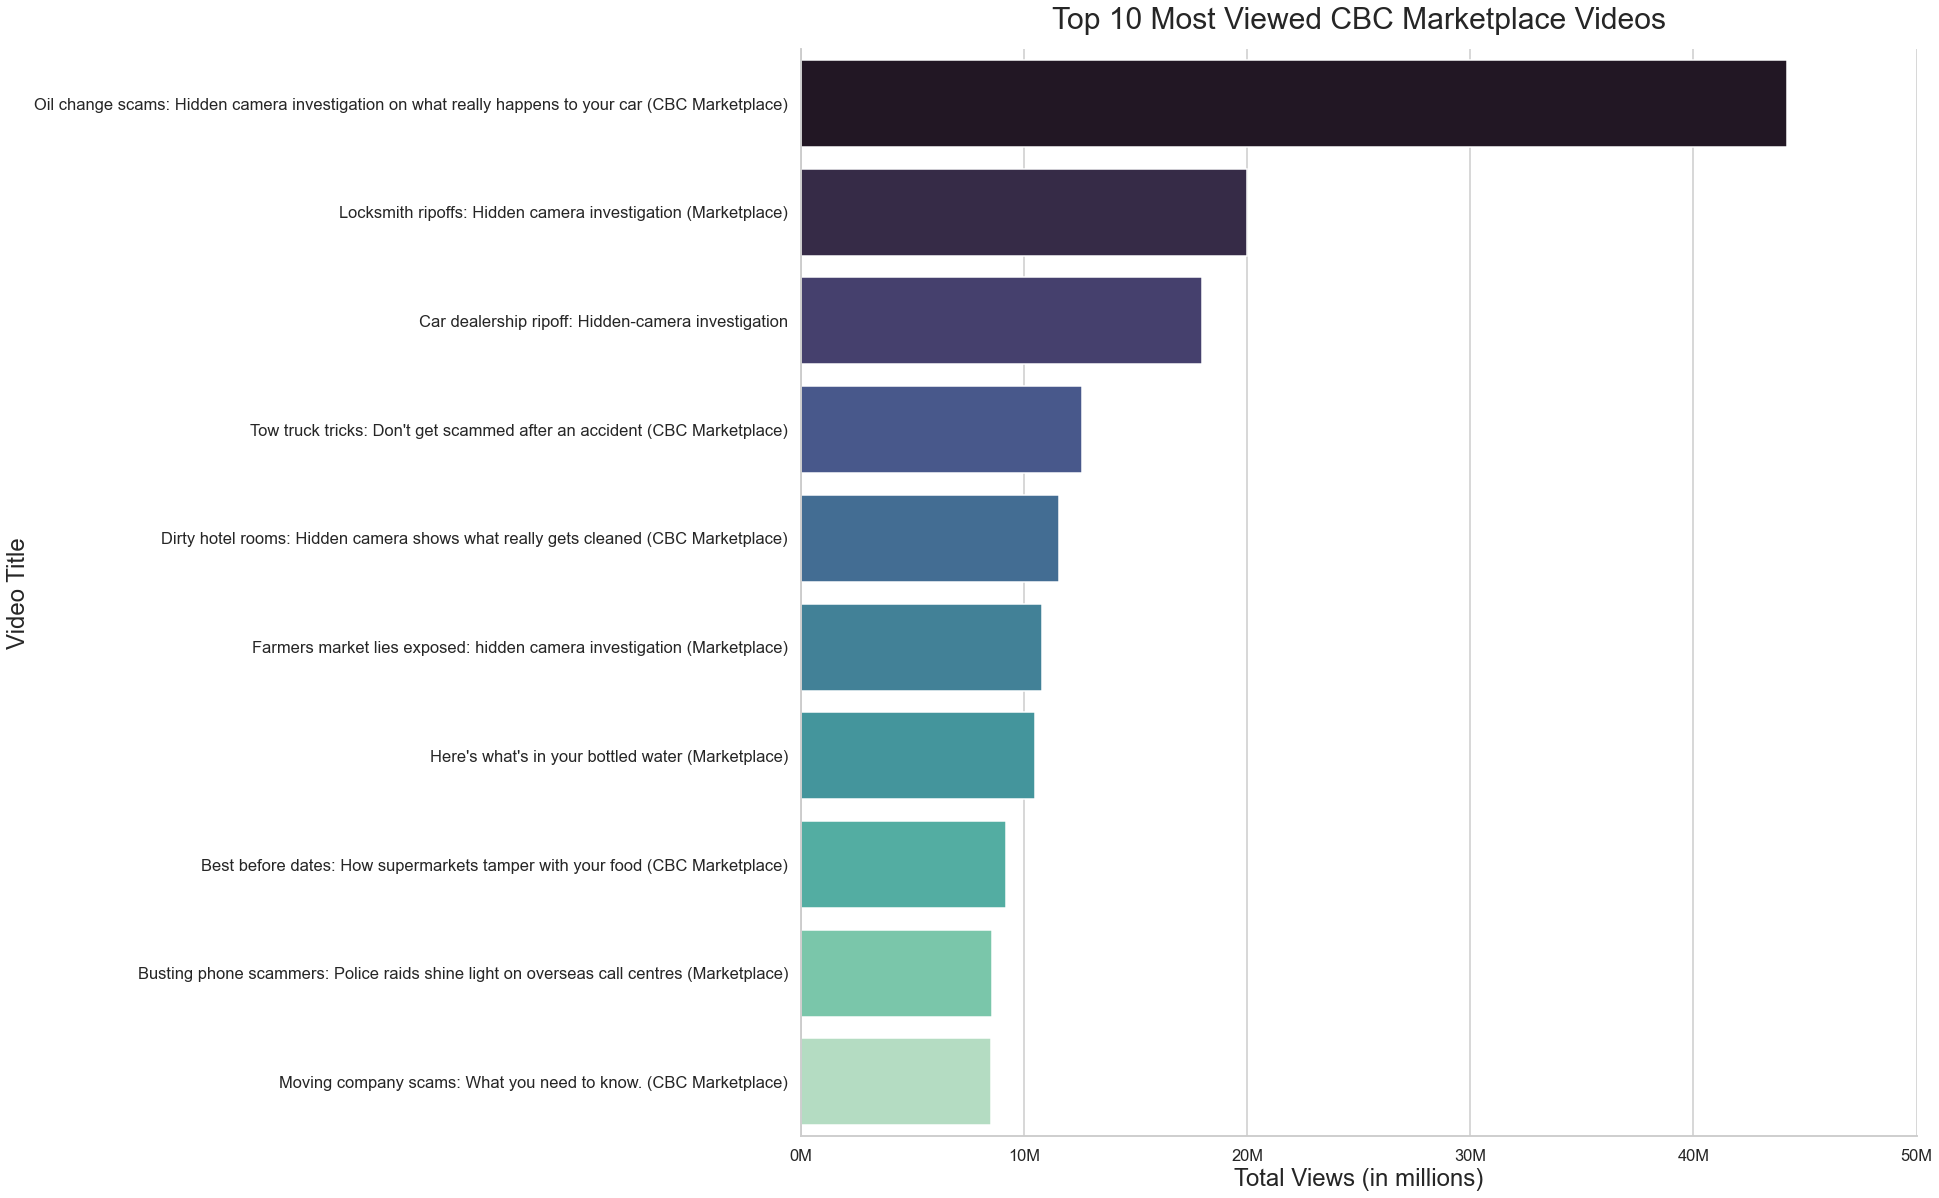

In [124]:
# Define plot size and aesthetics
sns.set_style('whitegrid')
# sns.set_context('talk')
plt.figure(figsize=(20, 20))

# Create a bartplot
fig = sns.barplot(y=top_10_videos['title'], x=top_10_videos['viewCount'], palette='mako')

# Set titles and labels
plt.title('Top 10 Most Viewed CBC Marketplace Videos', size=30, pad=20)
plt.xlabel('Total Views (in millions)', size=24)
plt.ylabel('Video Title', size=24)

# Set xlabels
fig.xaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x / 1_000_000) + 'M')

# Set axis limit
plt.xlim(0, 50_000_000)

# Remove top and right axes
sns.despine()

plt.show(fig)

The most popular video was the `Oil change scams: Hidden camera investigation on what really happens to your car` and the best performing video. 

There are 2 other car-related videos in the top 4 most popular videos:
- Car dealership ripoff: Hidden-camera investigation
- Tow truck tricks: Don't get scammed after an accident

This may reflect Canadians interest in topics related to their vehicle. An opportunity for gauging the popularity and interest of a video and topic can be done by estimating how many Canadians can potentially benefit from the knowledge and insights from a video. For instance, there are about [26.2 million](https://www.statcan.gc.ca/en/topics-start/automotive) registered vehicles in Canada in 2021. And every vehicle requires oil changes depending on their mileage and owner's manual instructions. Google trends for Canada reveal the `oil change` search term's interest over time steadily increased since 2004, reaching 50% of [peak popularity](https://newsinitiative.withgoogle.com/resources/lessons/google-trends-understanding-the-data/#:~:text=Reading%20the%20Interest%20Over%20Time%20graph.&text=Hovering%20your%20mouse%20over%20the,of%20searches%20done%20on%20Google.) around the video's release (Nov 2013) and 100% in Aug 2022.  Furthermore, more than 1 million new motor vehicles are purchased by [Canadian motorists every year](https://www.statista.com/statistics/423012/motor-vehicle-sales-in-canada/), adding to more vehicle owners in Canada and potential viewers of the video over time.

#### What are the most common words in the video comments for the most popular video?

First, extract all the comments from the, `Oil change scams: Hidden camera investigation on what really happens to your car` video using the `get_video_comments` function. Note that the video id is `-avpx8UTakI` an input into the function and only top-level comments are extracted.

In [57]:
# comments_df = get_video_top_level_comments(youtube_api, '-avpx8UTakI')

In [58]:
# # Saving the data as a pickle file
# with open('comments_df.pickle', 'wb') as f:
#     pickle.dump(comments_df, f)

In [59]:
# Loading the pickle file into a variable
with open('comments_df.pickle', 'rb') as f:
    comments_df = pickle.load(f)

In [60]:
comments_df

,VideoComment
0,99% of mechanic shops are scam artists
1,the best way to avoid this is to know your stuff
2,"I have 1 mechanic, I've known my whole life, N..."
3,Gettem Tom!
4,Good piece of work folks
...,...
22231,My friends have always asked why I don't have ...
22232,"Only in North America, otherwise anyone doing ..."
22233,That fucking piece of shit should get sued and...
22234,Supersize me


To generate a wordcloud using the comments data, I will first load a pre-configured stopwords list using the NLTK library and then form a corpus of all the words from the comments and load it into a word cloud generator.

In [61]:
stop_words = set(stopwords.words('english'))

Added additional stopwords prior to wordcloud visualization.

In [62]:
stop_words.update(['oil', 'change', 'car', 'get'])

Apply the `text_preprocess` function to the video comments.

In [63]:
comments_df['CommentWords'] = comments_df['VideoComment'].apply(lambda x: text_preprocess(x))

Join the words of all the comments together into a single corpus.

In [64]:
all_comment_words = ' '.join(comments_df['CommentWords'])

Generate the wordcloud.

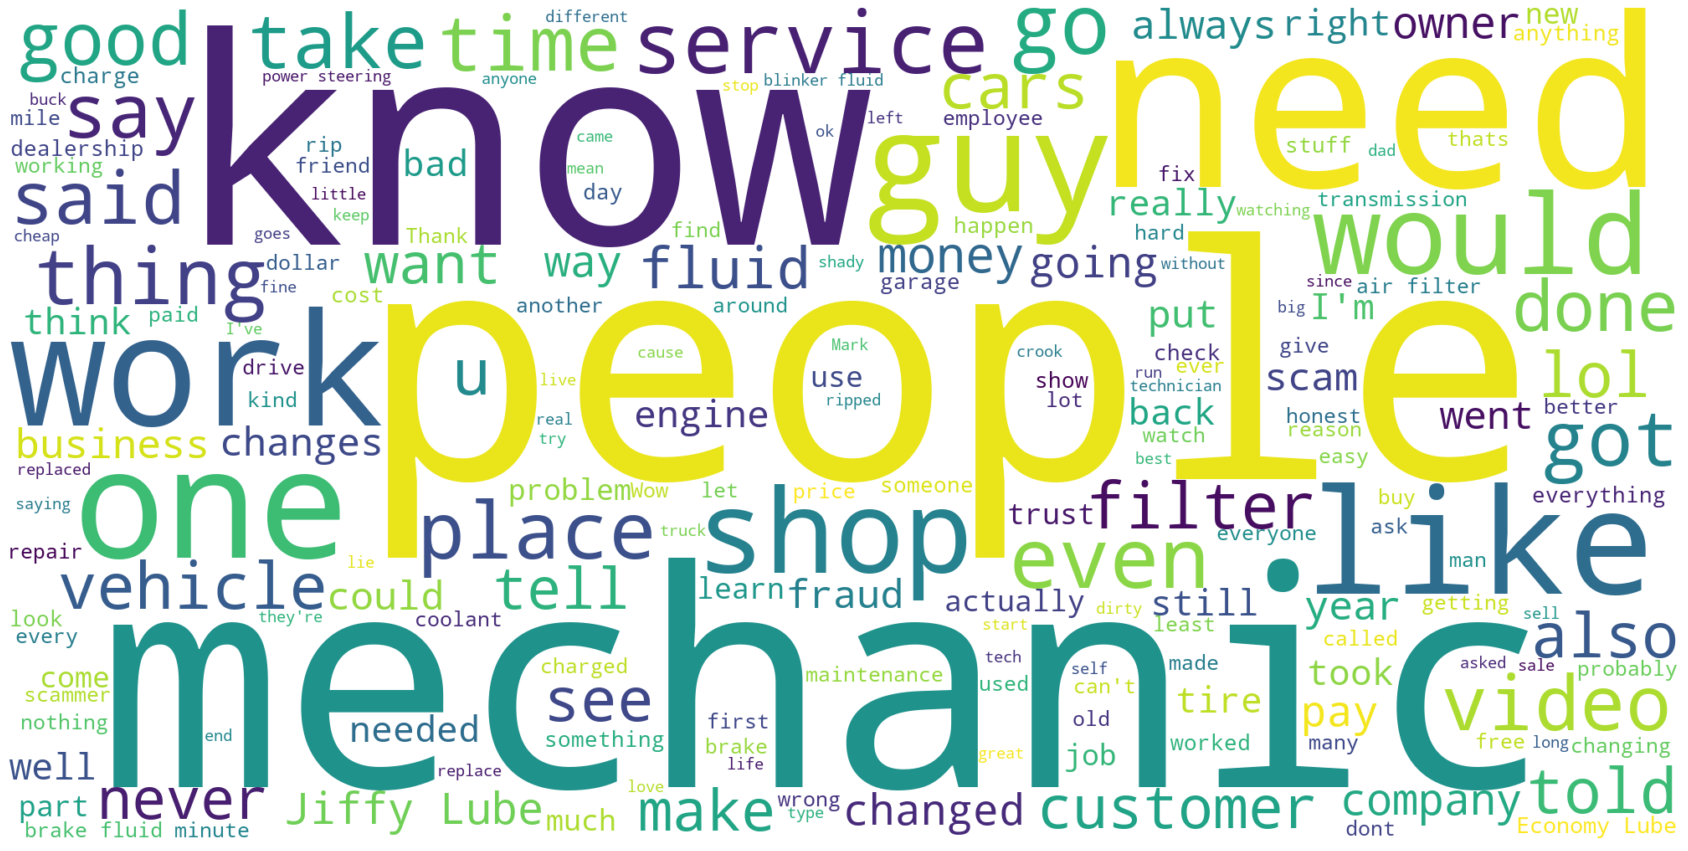

In [126]:
# Convert the comments corpus into a word cloud
wordcloud = WordCloud(width=2000,
                      height=1000,
                      stopwords = stop_words,    # Set the list of stopwords to remove from the text
                      background_color='white',    # Set the background color of the wordcloud to white
                      colormap='viridis',
                      prefer_horizontal=1.0,    # Set all words to show horizontally
                      random_state=0    # Set the random state to ensure reproducibility of the results
                      ).generate(all_comment_words)

# Plot the wordcloud figure
plt.figure(figsize=(30, 16))
plt.imshow(wordcloud, interpolation="bilinear")    # Display the wordcloud image using bilinear interpolation for smoother display
plt.axis('off')    # Remove the axis ticks and labels from the plot
    
plt.show()

From the comments, common terms such as people, mechanic, need and know stand out. Specific company names, such as Jiffy Lube and Economy Lube also show up, potentially reflecting commentor negative experiences at those service shops, as talked about [here](https://www.cbc.ca/news/canada/oil-change-shop-caught-scamming-customers-marketplace-investigation-1.2418675). Negative sentimented words, such as fraud, bad, dirty, shady, problem, scam also appear. Positive sentimented words such as good, love, better are also observed. In addition, other car-related items also appear, such as brake fluid, air filter, power steering, brake, fluid, tire  with some comments suggesting unethical practices in conjunction with an oil change.

More NLP processing is required to remove additional stopwords and entity recognition for specific word class analyses.

#### What are the 10 least popular CBC Marketplace videos?

In [66]:
# Sort dataframe by viewCount and store as new variable
bottom_10_videos = video_df.sort_values(by='viewCount', ascending=False).tail(10)

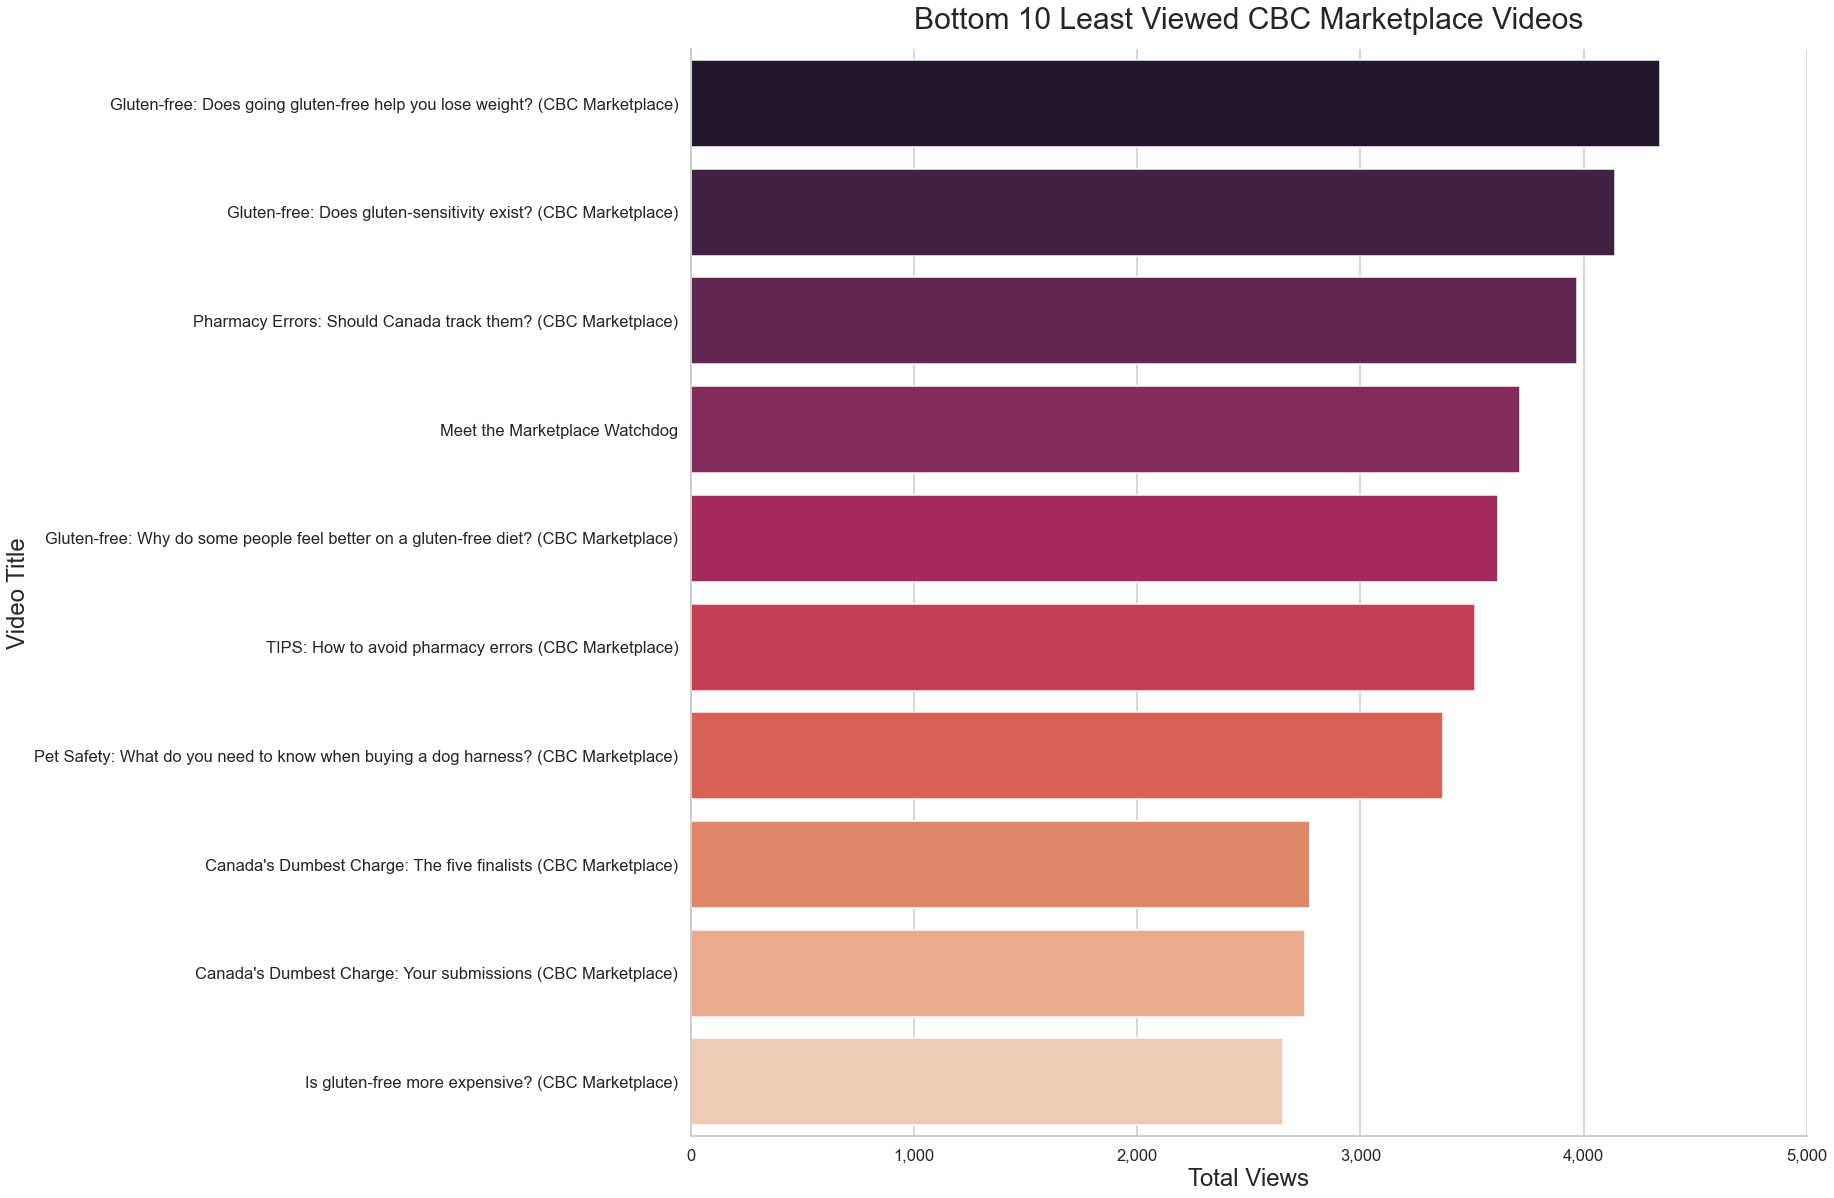

In [127]:
# Define plot size
plt.figure(figsize=(20, 20))

# Set figure aethetics
sns.set_style('whitegrid')

# Set scaling plot element
sns.set_context('talk')

################### Barplot ###################
# Create figure
fig = sns.barplot(
    y=bottom_10_videos['title'], x=bottom_10_videos['viewCount'], palette='rocket'
)

# Set titles and labels
plt.title('Bottom 10 Least Viewed CBC Marketplace Videos', size=30, pad=20)
plt.xlabel('Total Views', size=24)
plt.ylabel('Video Title', size=24)

# Set xlabels
fig.xaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x))

# Set axis limit
plt.xlim(0, 5_000)

# Remove top and right axes
sns.despine()


plt.show(fig)

The 10 least popular videos include gluten-free topics, in which 4 of the 10 are gluten-related and garnered less than 5,000 views each. Gluten-free is commonly associated with celiac disease. In Canada, this affects approximately 340,000 people, which is about [1% of Canada's population](https://www.canada.ca/en/health-canada/services/food-nutrition/food-safety/food-allergies-intolerances/celiac-disease/health-canada-position-gluten-free-claims.html_). In reference to the most popular CBC Marketplace video on oil change scams, comparing the number of Canadians affected by celiac disease (340,000) and gluten-free to the number of Canadian vehicle owners (21,000,000), there is a large difference between the two magnitudes that my inference is being made in relation to the number of Canadians a video topic can potentially garner interest. When [comparing the search interest over time in Canada on Google Trends](https://trends.google.com/trends/explore?date=all&geo=CA&q=%2Fm%2F034n2g,oil%20change), a `gluten-free diet` has been shown to be searched, on average, twice greater than that of `oil change`. Interestingly, when comparing search interest over time with `oil change` to `gluten-free`, `oil change` is [searched 16 times more](https://trends.google.com/trends/explore?date=all&geo=CA&q=Gluten-free,oil%20change), on average, than `gluten-free`. Only one of the four videos contain the title `gluten-free diet`. This may reflect an importance of optimizing the title of the videos by associating it with more popularly searched terms. However, that would depend largely on how people encounter and watch CBC Marketplace videos and does not account for any the views achieved through CBC's other communication channels, such as their website hosted videos.

#### What is the distribution of views across the videos?

Create a static boxplot visualization.

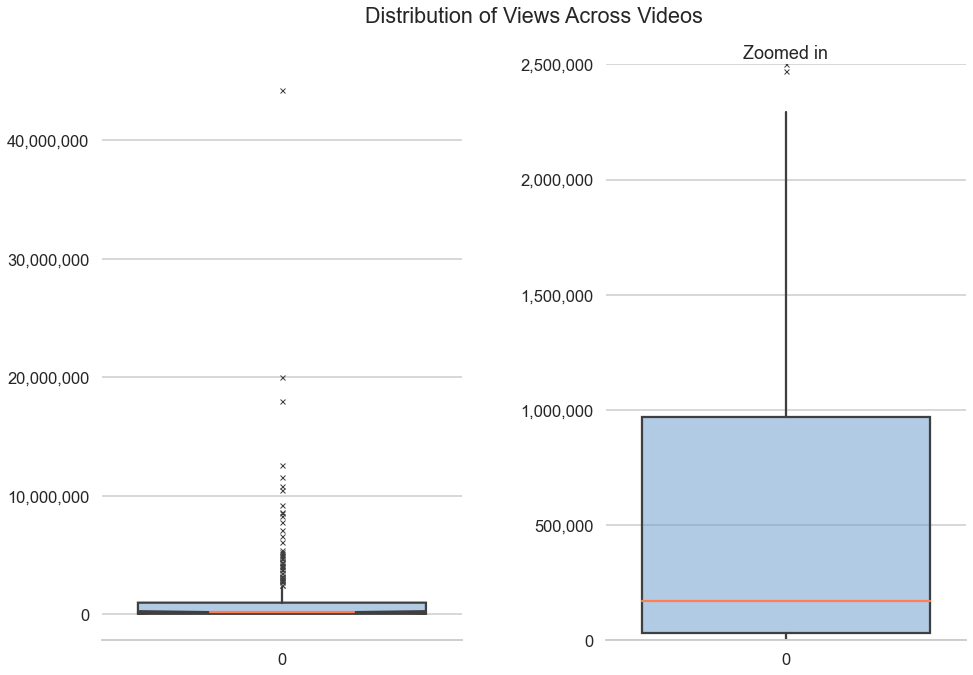

In [68]:
# Define plot size
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Figure title
fig.suptitle('Distribution of Views Across Videos')

# Subplot spacing
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

################### Subplot 1 ###################
sns.boxplot(
    ax=axes[0],
    data=video_df['viewCount'],
    notch=True,
    showcaps=False,
    flierprops={'marker': 'x'},
    boxprops={'facecolor': (0.4, 0.6, 0.8, 0.5)},
    medianprops={'color': 'coral'},
)

# Set ylabels
axes[0].yaxis.set_major_formatter(lambda y, pos: '{:,.0f}'.format(y))


################### Subplot 2 ###################
sns.boxplot(
    ax=axes[1],
    data=video_df['viewCount'],
    showcaps=False,
    flierprops={'marker': 'x'},
    boxprops={'facecolor': (0.4, 0.6, 0.8, 0.5)},
    medianprops={'color': 'coral'},
)

# Subplot title
axes[1].set_title('Zoomed in')

# Set ylabels
axes[1].yaxis.set_major_formatter(lambda y, pos: '{:,.0f}'.format(y))

# Set axis limit
plt.ylim(0, 2_500_000)

# Remove top and right axes
sns.despine(left=True)

# Remove top and right axes
plt.show()

Create an alternative interactive violin plot with boxplot visualization.

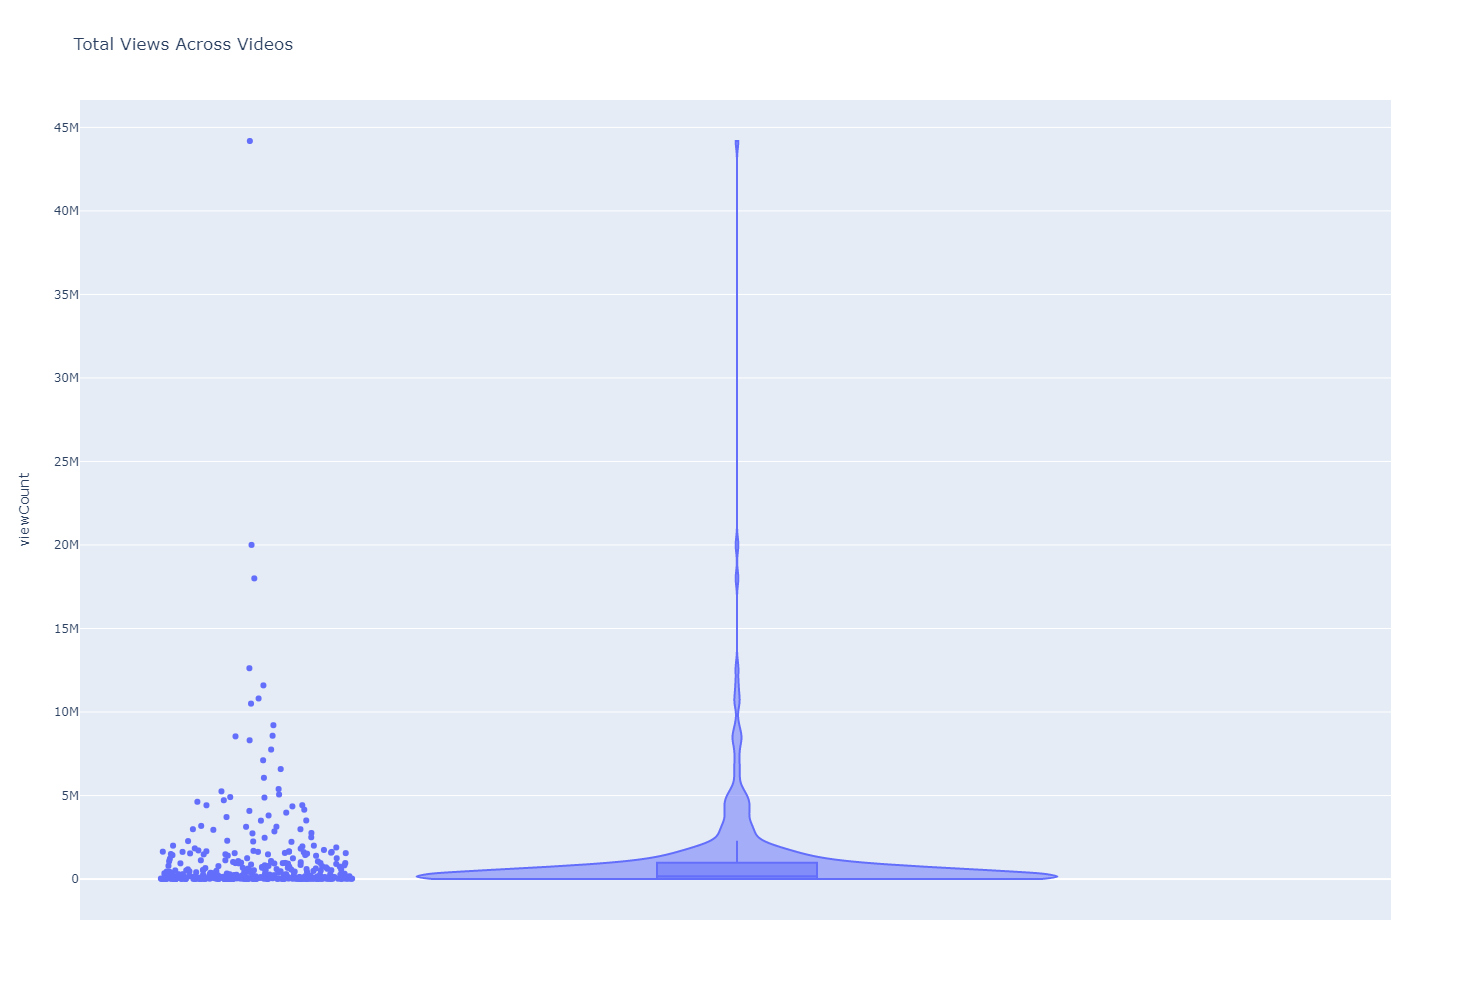

In [128]:
# Plot violin and boxplot
fig = px.violin(video_df,
                y='viewCount',
                points='all',
                box=True,
                title='Total Views Across Videos',
                width=1000,
                height=1000)

# Limit data bounds to min and max of dataset
fig.data[0].update(spanmode='hard')


fig.show()

The violin and boxplot shows that the total views observed across videos are not normally distributed and heavily skewed to the right, based on the violinplot's distribution and the boxplot's median line being closer to the bottom of the box. A wide range and variability of total views is observed, with videos achieving a median of 170,000 views. Majority of videos achieved between 30,000 and 1,000,000 views, while some other videos are as low as 2,600 and as high as 2,300,000 views. There are numerous outliers in the data with videos achieving millions of total views, which is significantly greater than what is typically observed within the data. These outliers may represent extremely popular and even viral videos that garnered widespread attention. A separate analysis would be beneficial in evaluating the factors that contributed to these videos achieving popularity, such as the video's topic, duration, quality, titles, tags, and so forth. Some of these factors will be briefly addressed in downstream analysis in this notebook.

#### Is there a relationship between the number of views and likes for a video? Comments? Tags? Duration? Title length?

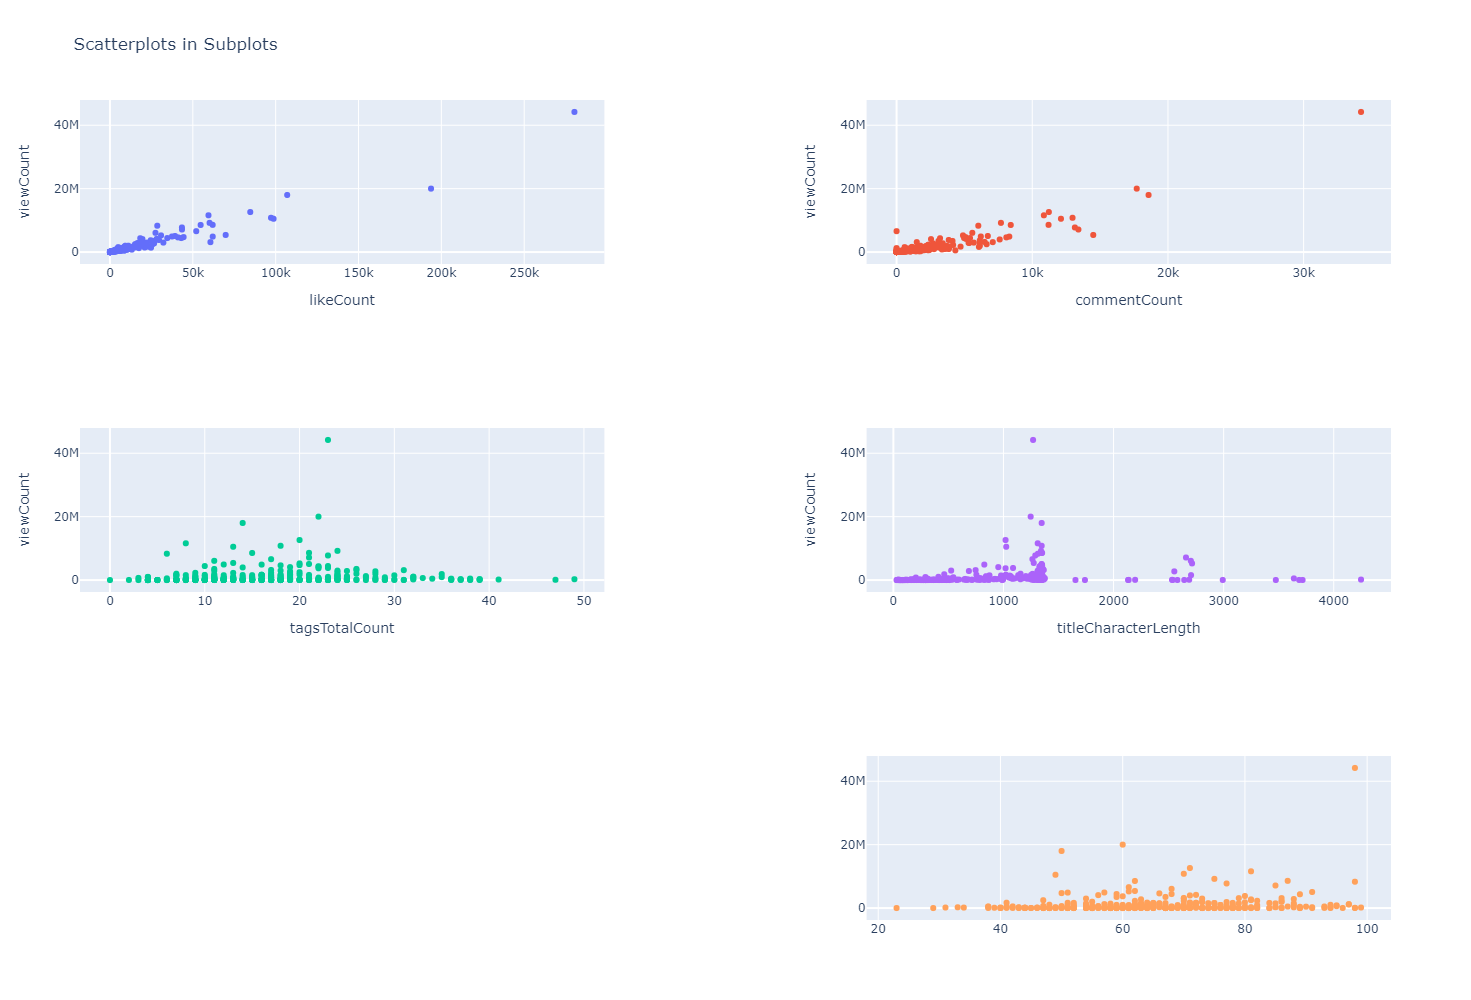

In [123]:
# Create a figure with 4 subplots arranged in 2 rows and 2 columns with padding between subplots
fig = make_subplots(rows=3, cols=2, vertical_spacing=0.2, horizontal_spacing=0.2)

# Add scatterplots to each subplot with only points, remove legend and set axes labels

################### Subplot 1 ###################
fig.add_trace(go.Scatter(x=video_df['likeCount'],
                         y=video_df['viewCount'],
                         mode='markers',
                         connectgaps=False),
              row=1,
              col=1)

fig.update_xaxes(title_text='likeCount', row=1, col=1)
fig.update_yaxes(title_text='viewCount', row=1, col=1)

################### Subplot 2 ###################
fig.add_trace(go.Scatter(x=video_df['commentCount'],
                         y=video_df['viewCount'],
                         mode='markers',
                         connectgaps=False),
              row=1,
              col=2)

fig.update_xaxes(title_text='commentCount', row=1, col=2)
fig.update_yaxes(title_text='viewCount', row=1, col=2)

################### Subplot 3 ###################
fig.add_trace(go.Scatter(x=video_df['tagsTotalCount'],
                         y=video_df['viewCount'],
                         mode='markers',
                         connectgaps=False),
              row=2,
              col=1)

fig.update_xaxes(title_text='tagsTotalCount', row=2, col=1)
fig.update_yaxes(title_text='viewCount', row=2, col=1)

################### Subplot 4 ###################
fig.add_trace(go.Scatter(x=video_df['durationInSeconds'],
                         y=video_df['viewCount'],
                         mode='markers',
                         connectgaps=False),
              row=2,
              col=2)

fig.update_xaxes(title_text='durationInSeconds', row=2, col=2)
fig.update_yaxes(title_text='viewCount', row=2, col=2)

# Update figure with no legend
fig.update_layout(height=1000, 
                  width=1000, 
                  title_text='Scatterplots in Subplots', 
                  showlegend=False)

################### Subplot 5 ###################
fig.add_trace(go.Scatter(x=video_df['titleCharacterLength'],
                         y=video_df['viewCount'],
                         mode='markers',
                         connectgaps=False),
              row=3,
              col=2)

fig.update_xaxes(title_text='titleCharacterLength', row=2, col=2)
fig.update_yaxes(title_text='viewCount', row=2, col=2)

# Update figure with no legend
fig.update_layout(height=1000, 
                  width=1000, 
                  title_text='Scatterplots in Subplots', 
                  showlegend=False)


# Show the plot
fig.show()

The scatterplots for `likeCount` and `commentCount` show a positive relationship with `viewCount`, indicating that with more views for a video, the more likes and comments a video will receive. However, as previously observed, there are numerous outliers in the dataset that are far from the main cluster of data points, which may influence the strength of the relationship. In addition, the scatterplot for `commentCount` shows a nonlinear relationship, with the data points exhibiting a curve at the main cluster of data points rather than a straight line. Further analysis would be required to evaluate the relationships upon removing outliers from the data.

In contrast, there is no clear positive or negative relationship between `tagsTotalCount`, `durationInSeconds`, and `titleCharacterLength` with `viewCount`. Many popular videos with millions of views had a range of total tags that generally spanned between 5-31 total tags and coincided with the range observed for all other videos. Majority of videos are about 1,300 seconds or less in duration. Interestingly, many of the videos with millions of total views are 1,300 seconds long or approximately 21 minutes. There are a handful of videos with millions of views that are about 2,500 seconds or about 41 minutes long. This indicates that video segments of about 21 minutes are an optimal duration for garnering popularity for YouTube. The duration appears to be the [full segment length broadcasted](https://en.wikipedia.org/wiki/Marketplace_(Canadian_TV_program)#:~:text=CBC%20Marketplace%20is%20a%20Canadian,tests%20government%20and%20industry%20promises.) on television. Majority of the videos' title  length range between 40-100 characters.

#### Is there a relationship between the ratio of views and likes for a video? Comments?

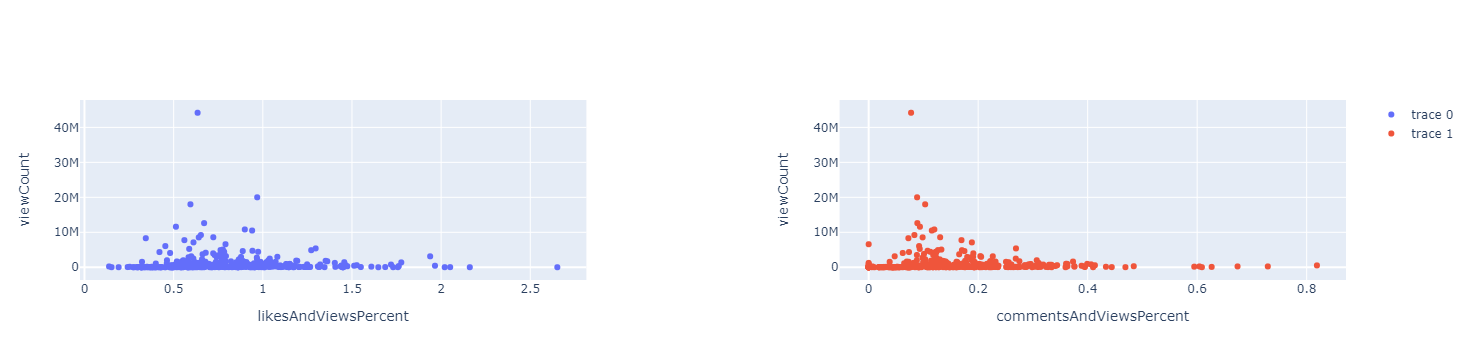

In [71]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a figure with 2 subplots arranged in 1 rows and 2 columns with padding between subplots
fig = make_subplots(rows=1, cols=2, vertical_spacing=0.2, horizontal_spacing=0.2)

# Add scatterplots to each subplot with only points, remove legend and set axes labels

################### Subplot 1 ###################
fig.add_trace(go.Scatter(x=video_df['likesAndViewsPercent'],
                         y=video_df['viewCount'],
                         mode='markers',
                         connectgaps=False),
              row=1,
              col=1)

fig.update_xaxes(title_text='likesAndViewsPercent', row=1, col=1)
fig.update_yaxes(title_text='viewCount', row=1, col=1)

################### Subplot 2 ###################
fig.add_trace(go.Scatter(x=video_df['commentsAndViewsPercent'],
                         y=video_df['viewCount'],
                         mode='markers',
                         connectgaps=False),
              row=1,
              col=2)

fig.update_xaxes(title_text='commentsAndViewsPercent', row=1, col=2)
fig.update_yaxes(title_text='viewCount', row=1, col=2)

# Show the plot
fig.show()

In reviewing the ratio of `likesAndViewsPercent` and `commentsAndViewsPercent` to `viewCount`, there is no clear direction of relationship observed, which is in contrast to the previous scatterplot of `likeCount` and `commentCount` to `viewCount`. It was previously observed that the magnitude of likes and comments generally increase with the more views a video has. However, a video with high views, such as the outliers with millions of total views, possessed a lower ratio of likes to views and comments to views, suggesting that user engagement was not strong in the form of likes and comments in contrast to videos with less views.

#### Which days of the week are the videos published/released?

In [72]:
# Compiled total videos published throughout the week
# and reindex the data in order of the weekdays
published_days_df = pd.DataFrame(video_df['publishedDayName'].value_counts())
weekdays_index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
published_days_df = published_days_df.reindex(weekdays_index)

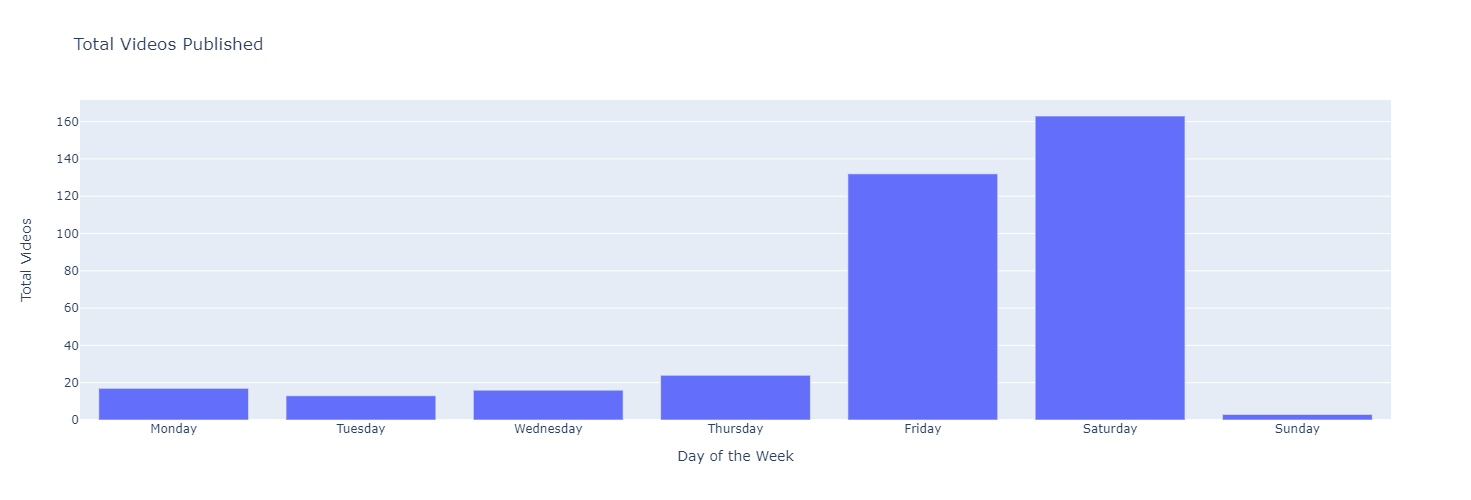

In [73]:
# Interactive Visualization using Plotly
fig = px.bar(published_days_df, x=weekdays_index, y = 'publishedDayName', title='Total Videos Published', width=800, height=500)

# Modify hover text annotation
fig.data[0].hovertemplate = 'Day of the Week=%{x}<br>Total Videos=%{y}<extra></extra>'

fig.update_xaxes(title_text='Day of the Week')
fig.update_yaxes(title_text='Total Videos')

CBC Marketplace videos are generally published on the Friday or Saturday, which appear to be aligned with when CBC Marketplace is aired on television, which is on [Fridays](https://www.cbc.ca/mediacentre/program/marketplace).

#### What are the most common words observed in the video titles?

Take all the video titles using the and then form a corpus of all the words and load it into a word cloud generator. For generating this wordcloud, I added additional stopwords prior to visualization.

In [74]:
stop_words.update(['CBC', 'Marketplace', 'Canada', 'Canada\'s', 'Canadian'])

Apply the `text_preprocess` function to the video titles.

In [75]:
video_df['titlewords'] = video_df['title'].apply(lambda x: text_preprocess(x))

Join all the words together into a single corpus.

In [76]:
all_title_words = ' '.join(video_df['titlewords'])

In [116]:
print(all_title_words)

Who's paying Investigating gender-based pricing Customers say pool builder took money never delivered Dog DNA testing kits How accurate What know palm Canada’s rental crisis The search affordable home Does diamond match deal We put test Sneaky fees How restaurants, gift cards tourist attractions costing Hidden camera investigation exposes man selling unproven alternative treatments Why phone plans expensive How much sodium food Boston Pizza, Earls, Joey Restaurants others Undercover investigation CDI College caught misleading students Buying balloons party Watch first Will motorcycle helmets keep safe We put test Can’t find jeans fit We tested Levi’s, H&M, Old Navy How survive inflation Busting movers Inside police raid HVAC scams Are protected Testing food labels Are claims good true The Waiting Game Investigating Canada’s health-care system Mortgage fraud caught camera Undercover investigation 50 years Using hidden camera, lab tests, secret trackers expose shady practices The trailbl

Generate the word cloud.

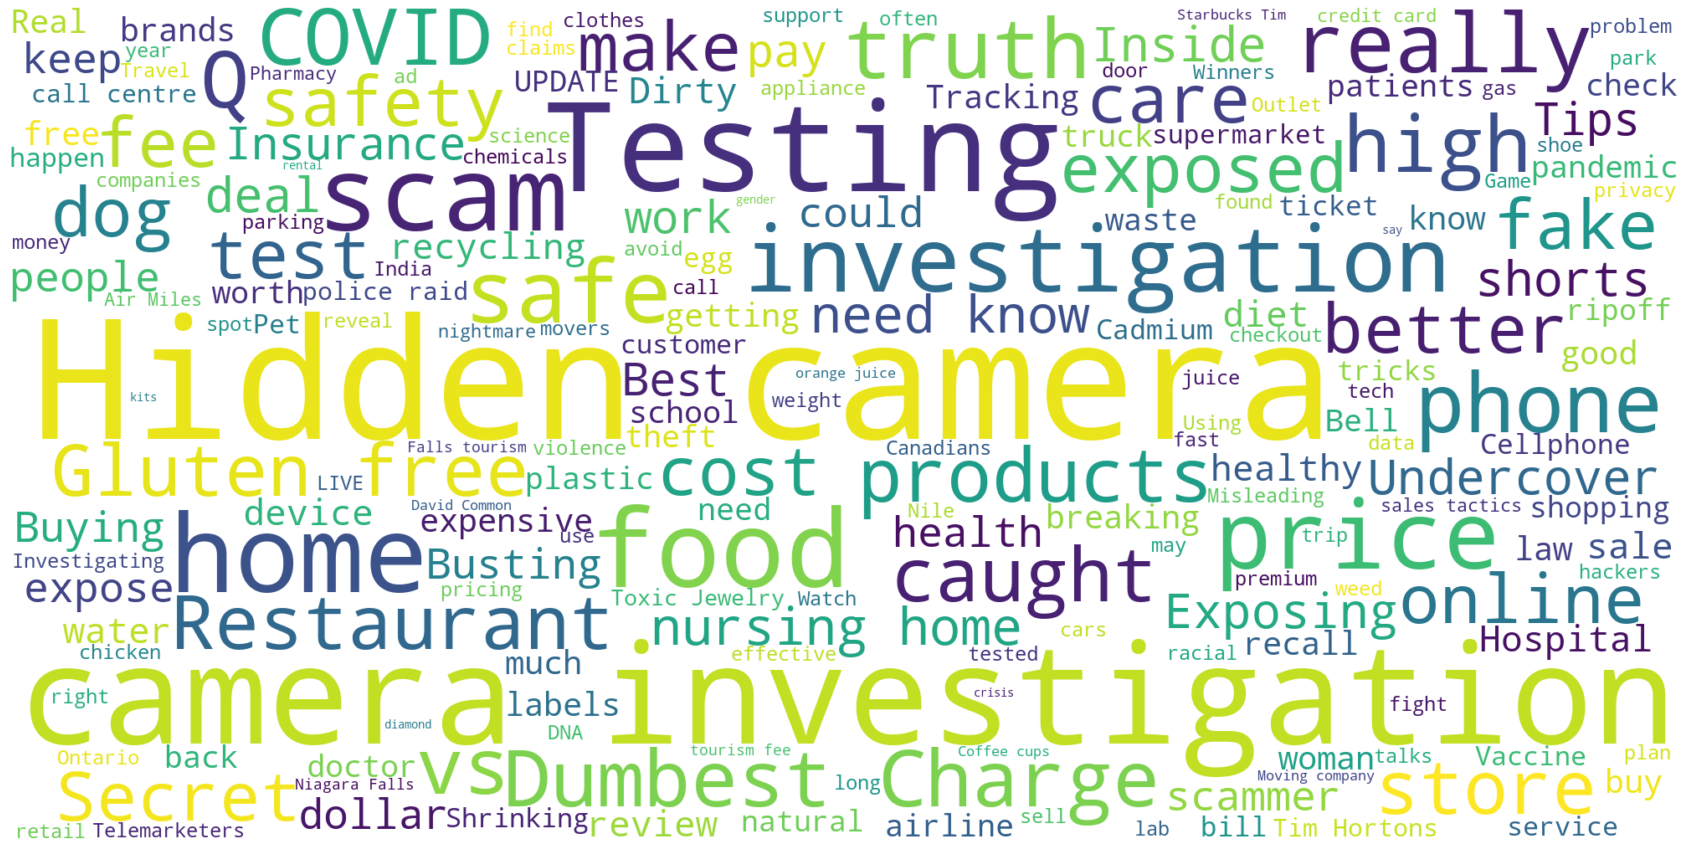

In [77]:
# Generate the wordcloud from the text data
wordcloud = WordCloud(width=2000,
                     height=1000,
                     stopwords = stop_words,
                     background_color='white',
                     colormap='viridis',
                     prefer_horizontal=1.0,
                     random_state=0).generate(all_title_words)

# Plot the wordcloud figure
plt.figure(figsize=(30, 16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

The wordcloud for video titles highlights a strong emphasis on covert investigations, capturing evidence on camera, and uncovering truths, with words like 'hidden camera', 'camera investigation', appearing the largest and most frequently in the wordcloud, with secondary related words such as 'tracking'. Similarly, there is an important theme on conducting some form laboratory testing, with the common appearance of the word 'testing' and 'science'. These topics are in relation to exposing scams, frauds, dirty tactics, with words such as: exposed', 'scam', 'fake', 'truth', 'sales tactics', 'undercover', 'misleading', and 'busting'. The specific topics these investigations are conducted on include: covid-19, food, gluten-free, insurance, supermarket, nursing home, and so forth. Some brand names also appear, such as Winners, Starbucks, Tim Hortons, and destinations, like Niagara Falls.

Overall, the text seems to be focused on exposing the truth to scams through undercover and hidden investigations on a wide range of topics that involve misleading or deceitful activities taking place.

Create an alternative wordlcoud using the CBC logo as a mask.

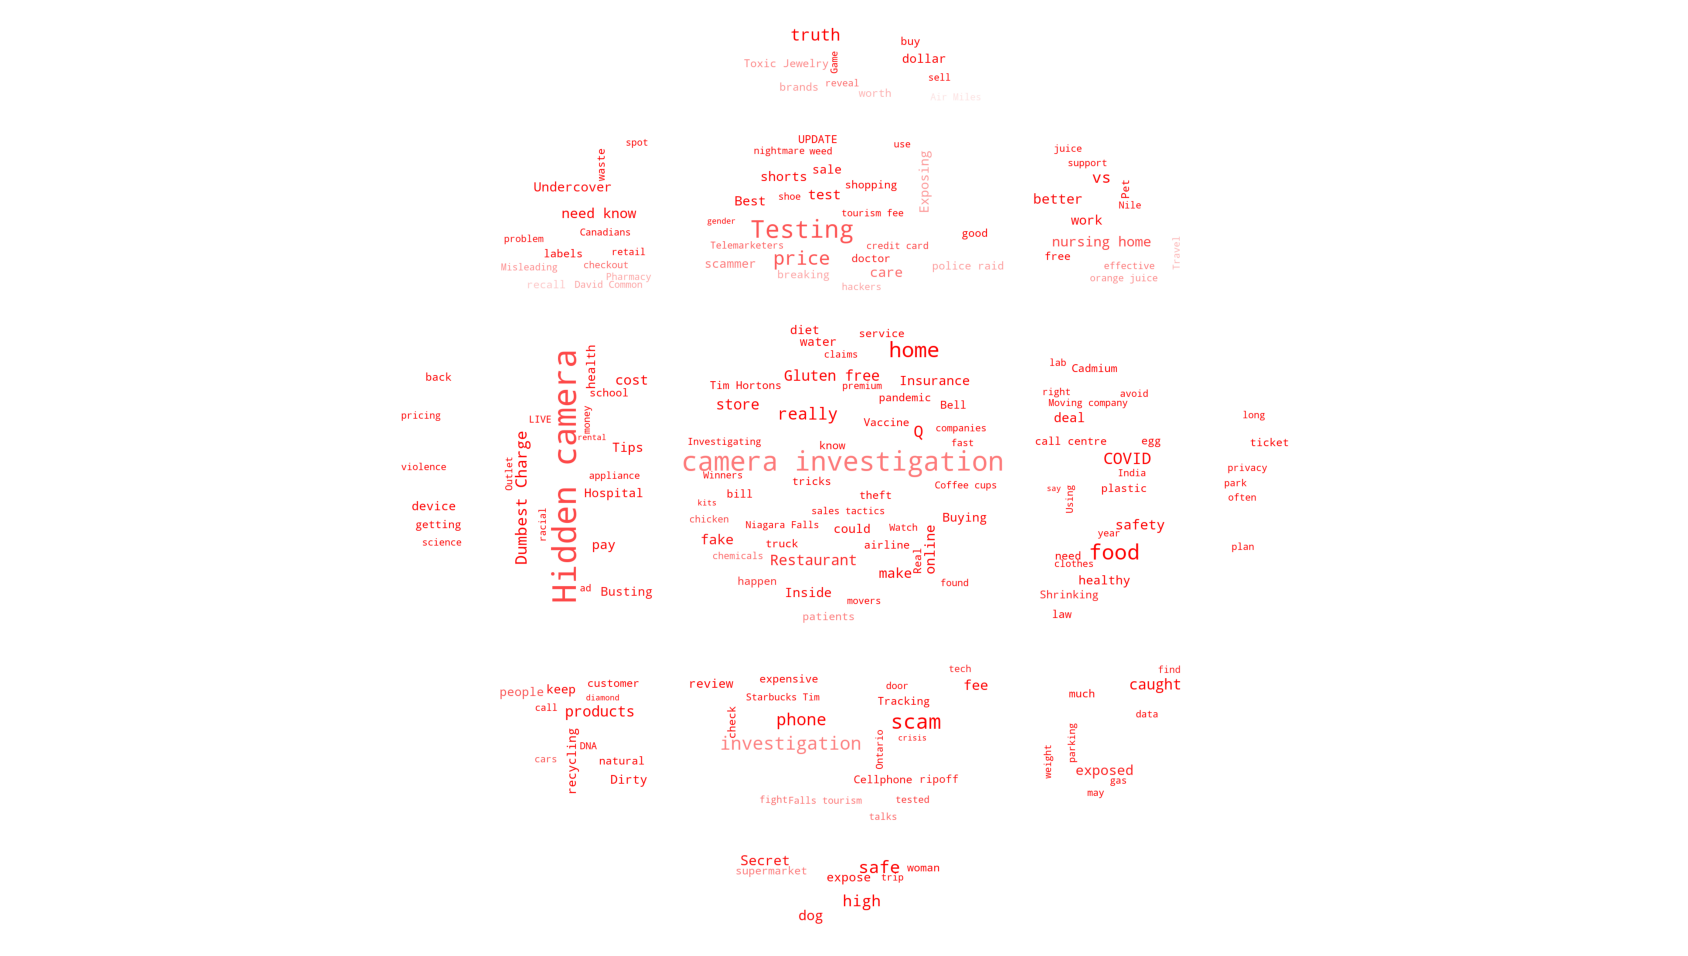

In [121]:
# Load in the mask image for the wordcloud
cbc_mask = np.array(Image.open("cbc-logo-red-white.jpg"))

# Generate the wordcloud from the text data
wc_cbc = WordCloud(width=2000,
                   height=1000,
                   stopwords = stop_words,
                   background_color='white',
                   # prefer_horizontal=1.0,
                   random_state=1,
                   max_words=2_000,    # Set the maximum number of words to display in the wordcloud
                   mask=cbc_mask    # Set the mask image to use for shaping the wordcloud
                  ).generate(all_title_words)

# Create a color palette based on the image mask of the cbc logo
image_colors = ImageColorGenerator(cbc_mask)

# Plot the wordcloud figure
plt.figure(figsize=(30, 20))
plt.imshow(wc, interpolation="bilinear")
plt.imshow(wc.recolor(color_func=image_colors))    # Recolor the wordcloud based on the image mask
plt.axis('off')

plt.show()

## Conclusions, Limitations, and Future Work

Global News is the most subscribed and viewed Canadian news YouTube channel, with CBC News following closely in second place. CityNews has uploaded the most videos, yet ranks 6th in subscribers and 5th in channel views, while CBC News ranks 4th in total videos published but 2nd in both subscribers and channel views.

Based on the most popular videos, the Canadian audience was most interested in uncovering unethical practices in relation to their vehicles, as seen from the popularity of car-related videos on oil change scams or car dealership tactics. A potential gauge for estimating the popularity of a video and topic can done by estimating how many Canadians can benefit from the knowledge and insights shared in the video. For instance, approximately 26 million vehicle owners were registered in 2021 in Canada, with every year seeing over a million of new car owners. Among the least popular videos, many gluten-free related videos were observed. However, when it comes to keyword search terms on Google Trends, there is an interesting trend, where "gluten-free diet" was more searched than "oil change" but "gluten-free" was the least searched in comparison. Optimizing the titles of videos to associate with more popularly searched terms could increase a video's access and popularity. However, inferring video popularity solely on YouTube views and connecting that with what Canadian interests are does not account for how many of the views come from outside of Canada and the views of videos through other media consumption channels, such as televised programming and CBC's website hosted video views.

The number of likes and comments a video accumulates is positively related with the total views of a video, although outliers in the data may influence the strength of the relationships observed. In addition, when likes and comments were percent normalized to total views, no relationship was observed. Videos with high view counts often have a lower ratio of likes to views and comments to views, suggesting that user engagement may not be as strong in contrast to videos with fewer views. Though there is no clear relationship between the total tags, title characters, or video duration on total views, many of the videos that achieved millions of views were generally around 21 minutes. 

CBC Marketplace is described as: "Canada's consumer watchdog series since 1972, this news program uncovers wrongdoings in the marketplace. With the help of hidden cameras, correspondents dish out the dirt on not so "clean" business practices. Once they get the evidence they need on tape, they apply pressure on businesses to change policies vis-a-vis the products and services they provide to the public."
CBC Marketplace's video titles align with their mission of uncovering unethical practices and exposing the truth in various industries to the public through covert investigations, hidden cameras, and laboratory testing. Furthermore, the frequent appearance of company brand names, destinations and everyday topics (e.g., food, health) suggests that the investigations are conducted on widely recognized entities and current events.

Based on the analysis of CBC Marketplace's YouTube channel, there are several potential avenues for future work. For instance, it may be beneficial to conduct additional analysis to determine which segments of the most popular videos are frequently viewed or replayed, as well as parts that are no longer viewed so that better understanding and insights into the content that resonates most with users can be achieved (although this type of analysis would be limited to the channel owners). Additionally, it could be beneficial to compare CBC Marketplace's approach to investigating scams and frauds with that of other similar channels to identify areas of differentiation and potential areas for improvement. Finally, given the prevalence of certain topics and brand names in CBC Marketplace's video titles, it may be worthwhile to explore and expand partnerships with companies or organizations or YouTube content creators to develop collaborative content that aligns with the channel's mission. For instance, many laboratory testing conducted through their videos include partnerships with other universities.

## References

1. [Youtube Data API Overview](https://developers.google.com/youtube/v3/getting-started)
2. [Youtube Data Resource Docs](https://developers.google.com/youtube/v3/docs)
3. [Youtube Data - Channels Resource JSON Structure](https://developers.google.com/youtube/v3/docs/channels#contentDetails)
4. [Tutorial Example 1](https://www.youtube.com/watch?v=D56_Cx36oGY)
5. [Tutorial Example 2](https://medium.com/mcd-unison/youtube-data-api-v3-in-python-tutorial-with-examples-e829a25d2ebd)
6. [Stackoverflow post on parsing duration](https://stackoverflow.com/questions/16742381/how-to-convert-youtube-api-duration-to-seconds)
7. [Plotly subplots documentation](https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html)
8. [Stackoverflow post on cancelling axis offset in Matplotlib](https://stackoverflow.com/questions/42713208/matplotlib-cancelling-the-offset-of-axis-introduced-in-matplotlib-2-0)
9. [Wordcloud with image documentation](https://amueller.github.io/word_cloud/auto_examples/colored.html)

Playlist:
- [CBC Marketplace Youtube Channel](https://www.youtube.com/playlist?list=PLeyJPHbRnGaZmzkCwy3-8ykUZm_8B9kKM)